<a href="https://colab.research.google.com/github/saziaa/Alzheimer-s_Stage_Classification/blob/main/Alzheimer%E2%80%99s_Stage_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# List physical devices and check if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    print(f"Using GPU: {physical_devices[0]}")
else:
    print("No GPU detected.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
!nvidia-smi

Fri Apr 11 15:52:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   43C    P8             16W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Importing Libraries**

In [ ]:
import os
import random
import zipfile
import shutil
import random
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extracting Files**

In [ ]:
# Path to the ZIP file in the Google Drive
zip_path = '/content/drive/MyDrive/Colab Notebooks/DeepLearningProject/Data.zip'

# Where to extract the files
extract_path = '/content/OASIS_Data'

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete! Files are now in:", extract_path)

Extraction complete! Files are now in: /content/OASIS_Data


**Checking Contents**

In [ ]:
#Check Contents After Extraction
base_path = "/content/OASIS_Data"

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"📁 {folder}: {num_files} files")


📁 Mild Dementia: 5002 files
📁 Non Demented: 67222 files
📁 Very mild Dementia: 13725 files
📁 Moderate Dementia: 488 files


**Visualizing MRI Images**

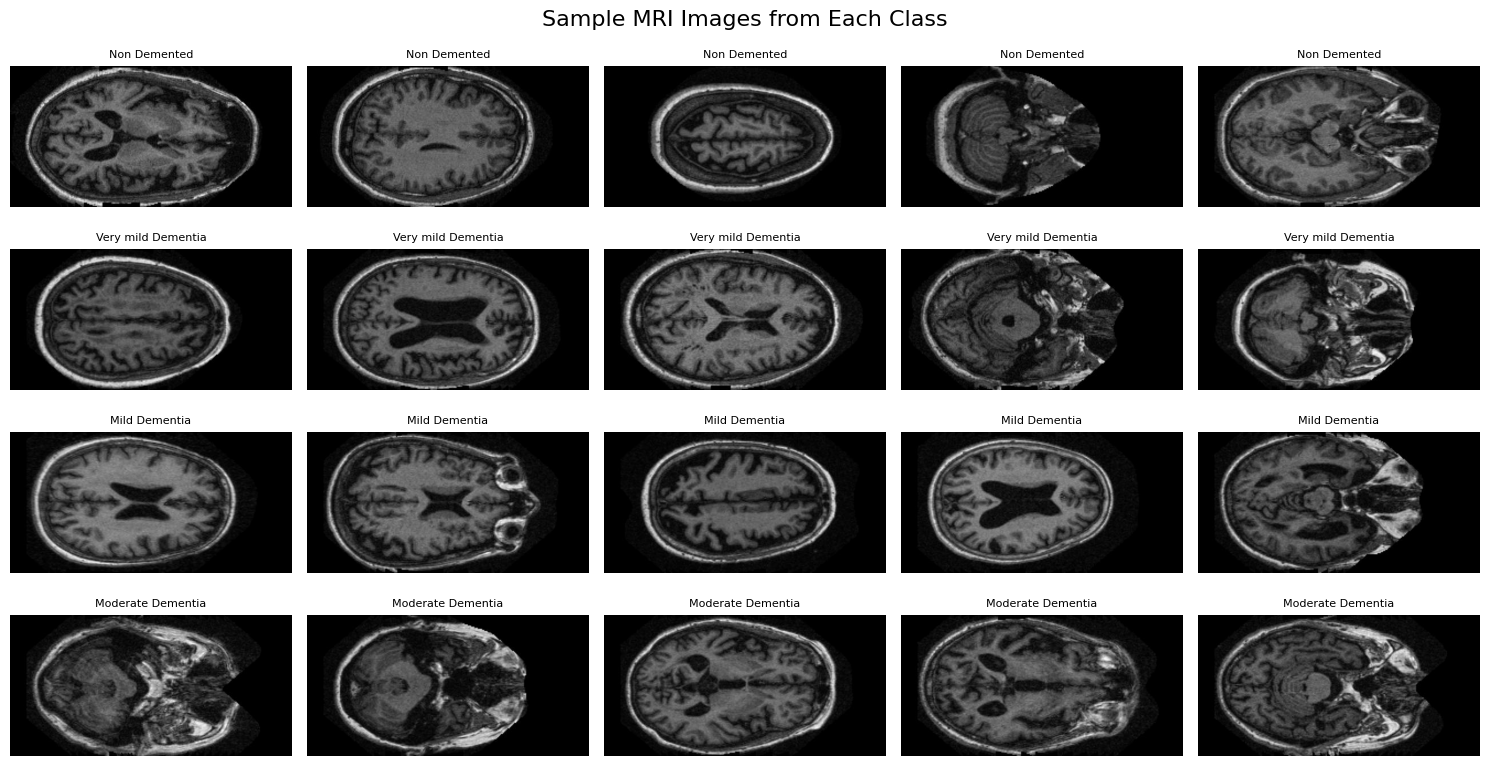

In [ ]:
# Visualization of the contents
# Set up paths
base_path = "/content/OASIS_Data"
classes = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']

# Number of images to show per class
num_images = 5

# Plot setup
plt.figure(figsize=(15, 8))

for idx, label in enumerate(classes):
    folder_path = os.path.join(base_path, label)
    image_files = random.sample(os.listdir(folder_path), num_images)

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)

        plt.subplot(len(classes), num_images, idx * num_images + i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(label, fontsize=8)  # Show label above each image


plt.suptitle("Sample MRI Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()


**Environment Setup**

In [ ]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Paths and parameters
base_path = '/content/OASIS_Data'
img_size = 224
batch_size = 64
epochs = 30

**Splitting Data**

In [ ]:
# Set paths
base_path = '/content/OASIS_Data'
split_base_path = '/content/OASIS_Data_Split'

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create split directories
for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_base_path, split)
    os.makedirs(split_path, exist_ok=True)

# Go through each class in the original directory
for class_name in os.listdir(base_path):
    class_path = os.path.join(base_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # List all image files in this class
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    total = len(images)
    train_end = int(train_ratio * total)
    val_end = train_end + int(val_ratio * total)

    splits = {
        'train': images[:train_end],
        'val': images[train_end:val_end],
        'test': images[val_end:]
    }

    # Copy files into new structure
    for split, image_list in splits.items():
        split_class_dir = os.path.join(split_base_path, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for image_file in image_list:
            src = os.path.join(class_path, image_file)
            dst = os.path.join(split_class_dir, image_file)
            shutil.copy2(src, dst)

print(" Dataset split into train, val, and test folders at:", split_base_path)


 Dataset split into train, val, and test folders at: /content/OASIS_Data_Split


**Data Preparation**

In [ ]:
# Paths for each set
train_path = '/content/OASIS_Data_Split/train'
val_path = '/content/OASIS_Data_Split/val'
test_path = '/content/OASIS_Data_Split/test'


# Data Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation and Test - only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed
)

# Validation generator
val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    seed=seed
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


Found 60504 images belonging to 4 classes.
Found 12964 images belonging to 4 classes.
Found 12969 images belonging to 4 classes.


**Visualizing Augmented MRI Images**

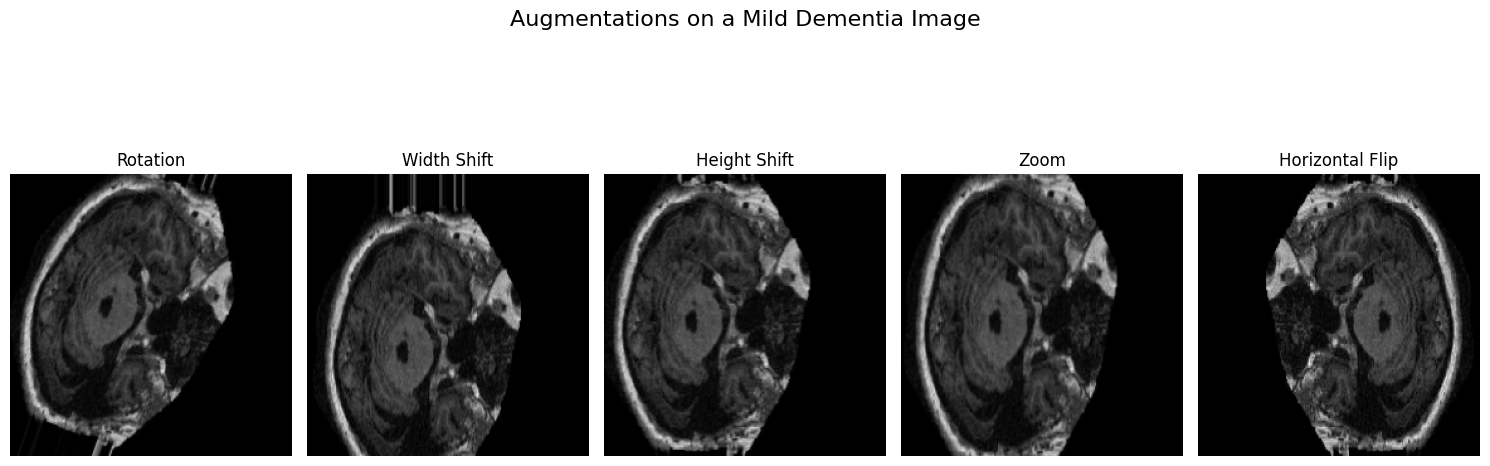

In [ ]:
# Define the augmentation
augmentor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Choose a class
class_name = "Mild Dementia"  # You can also try "Non Demented", "Very mild Dementia", "Moderate Dementia"
folder_path = f"/content/OASIS_Data/{class_name}"

# Get a random image from that class
image_files = os.listdir(folder_path)
random_img = random.choice(image_files)
img_path = os.path.join(folder_path, random_img)

# Load and preprocess the image
img = load_img(img_path, target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Define augmentations
augmentations = {
    "Rotation": ImageDataGenerator(rescale=1./255, rotation_range=30),
    "Width Shift": ImageDataGenerator(rescale=1./255, width_shift_range=0.2),
    "Height Shift": ImageDataGenerator(rescale=1./255, height_shift_range=0.2),
    "Zoom": ImageDataGenerator(rescale=1./255, zoom_range=0.2),
    "Horizontal Flip": ImageDataGenerator(rescale=1./255, horizontal_flip=True)
}

# Plot augmented versions
plt.figure(figsize=(15, 6))

for i, (label, datagen) in enumerate(augmentations.items()):
    aug_iter = datagen.flow(x, batch_size=1)
    aug_img = next(aug_iter)[0]

    plt.subplot(1, 5, i+1)
    plt.imshow(np.clip(aug_img * 255, 0, 255).astype(np.uint8))
    plt.title(label)
    plt.axis('off')

plt.suptitle(f"Augmentations on a {class_name} Image", fontsize=16)
plt.tight_layout()
plt.show()

 **Build the Model**

In [ ]:
# VGG16 Base
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))
base_model.trainable = False #freeze initially

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


**Plotting the Model**

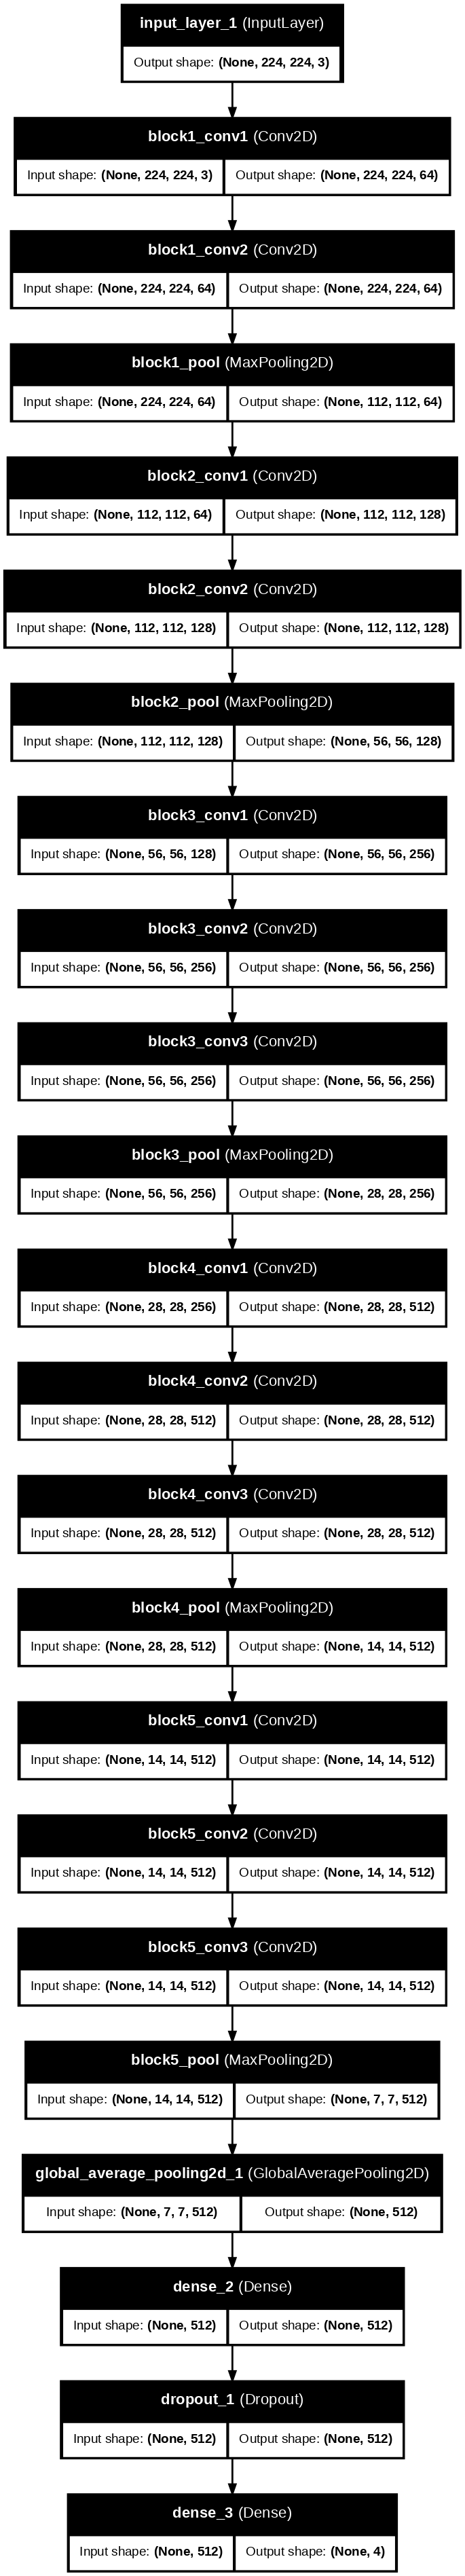

In [ ]:
# Generate diagram
plot_model(model,
           to_file='vgg16_model_colored.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True,
           dpi=100)

**Training VGG16(Frozen Model)**

In [ ]:
checkpoint_path = '/content/drive/MyDrive/best_vgg16_model.keras'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


946/946 ━━━━━━━━━━━━━━━━━━━━ 721s 759ms/step - accuracy: 0.3207 - loss: 1.4333 - val_accuracy: 0.4514 - val_loss: 1.3140 - learning_rate: 1.0000e-04
Epoch 2/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 709s 749ms/step - accuracy: 0.4261 - loss: 1.2970 - val_accuracy: 0.4942 - val_loss: 1.1873 - learning_rate: 1.0000e-04
Epoch 3/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 705s 745ms/step - accuracy: 0.4814 - loss: 1.2491 - val_accuracy: 0.6061 - val_loss: 1.0578 - learning_rate: 1.0000e-04
Epoch 4/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 707s 747ms/step - accuracy: 0.5265 - loss: 1.1952 - val_accuracy: 0.6081 - val_loss: 1.0386 - learning_rate: 1.0000e-04
Epoch 5/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 707s 747ms/step - accuracy: 0.5457 - loss: 1.1594 - val_accuracy: 0.6370 - val_loss: 0.9695 - learning_rate: 1.0000e-04
Epoch 6/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 712s 752ms/step - accuracy: 0.5576 - loss: 1.1339 - val_accuracy: 0.6510 - val_loss: 0.9169 - learning_rate: 1.0000e-04
Epoch 7/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 705s 745ms/

**Visualizing Training and Validation Accuracy/Loss(Frozen Model)**

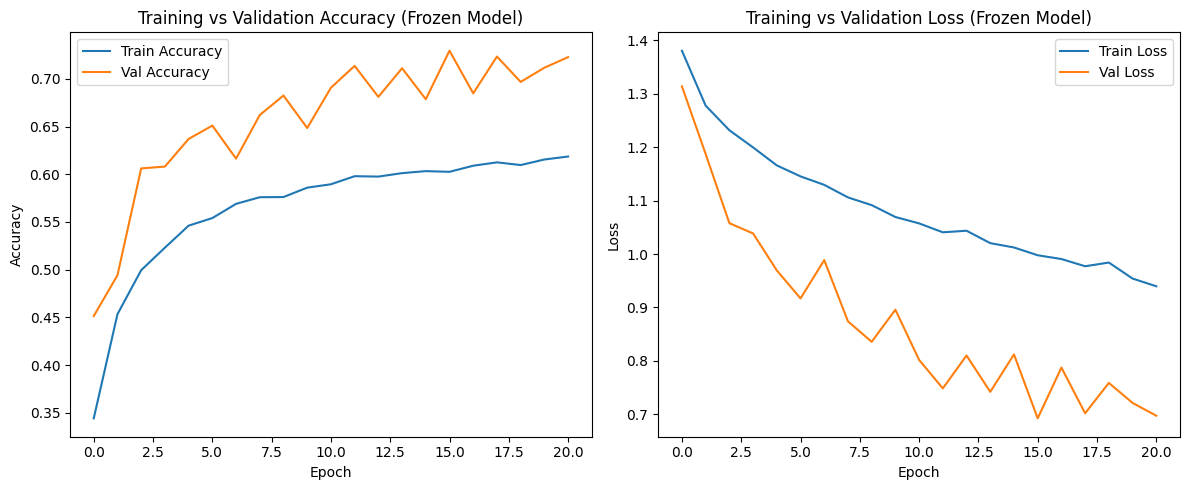

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'],  label='Train Accuracy')
plt.plot(history.history['val_accuracy'],  label='Val Accuracy')
plt.title('Training vs Validation Accuracy (Frozen Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'],  label='Val Loss')
plt.title('Training vs Validation Loss (Frozen Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


In [ ]:
# Save the full model to a local file in the current session
model.save('frozen_model.keras')

**Evaluation(Frozen Model)**

**a.Evaluate on Test Set(Frozen Model)**

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

203/203 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - accuracy: 0.7677 - loss: 0.6621
Test Accuracy: 73.24%
Test Loss: 0.6864


In [ ]:
# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


203/203 ━━━━━━━━━━━━━━━━━━━━ 32s 151ms/step


**b. Confusion Matrix(Frozen Model)**

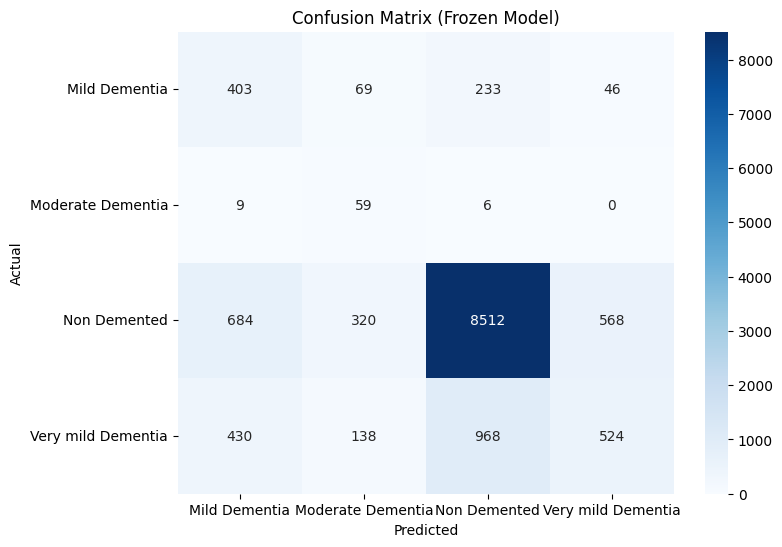

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Frozen Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**c. Classification Report(Frozen Model)**


In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

                    precision    recall  f1-score   support

     Mild Dementia       0.26      0.54      0.35       751
 Moderate Dementia       0.10      0.80      0.18        74
      Non Demented       0.88      0.84      0.86     10084
Very mild Dementia       0.46      0.25      0.33      2060

          accuracy                           0.73     12969
         macro avg       0.43      0.61      0.43     12969
      weighted avg       0.77      0.73      0.74     12969



**d. ROC Curve(Frozen Model)**

203/203 ━━━━━━━━━━━━━━━━━━━━ 32s 155ms/step


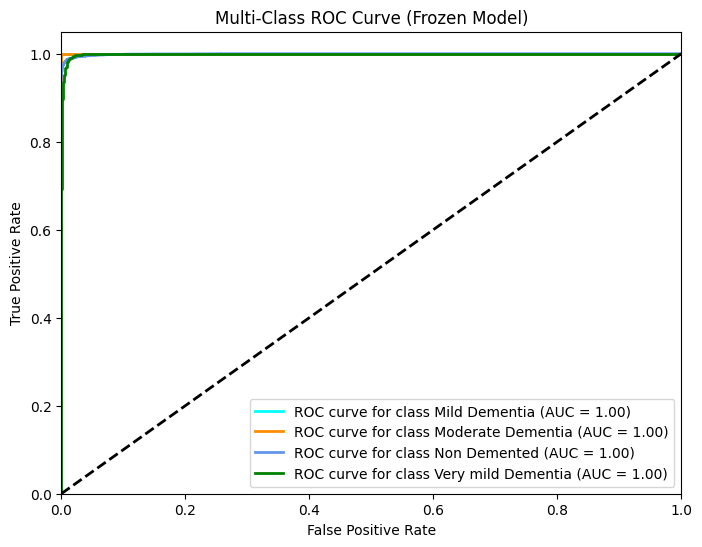

In [ ]:
# Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
n_classes = y_pred_probs.shape[1]

# Binarize the true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=range(n_classes))
class_names = list(test_generator.class_indices.keys())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Frozen Model)')
plt.legend(loc='lower right')

plt.show()


**TTraining Fine-Tune VGG16 (Unfrozen Model)**

In [ ]:
# Unfreeze the last 4 VGG layers
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Compile with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    ModelCheckpoint('best_finetuned_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

# Fit the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.6170 - loss: 0.9800
Epoch 1: val_accuracy improved from -inf to 0.77831, saving model to best_finetuned_model.keras
946/946 ━━━━━━━━━━━━━━━━━━━━ 703s 739ms/step - accuracy: 0.6171 - loss: 0.9799 - val_accuracy: 0.7783 - val_loss: 0.5085 - learning_rate: 1.0000e-05
Epoch 2/70
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 688ms/step - accuracy: 0.6739 - loss: 0.7852
Epoch 2: val_accuracy did not improve from 0.77831
946/946 ━━━━━━━━━━━━━━━━━━━━ 682s 721ms/step - accuracy: 0.6739 - loss: 0.7852 - val_accuracy: 0.7547 - val_loss: 0.5829 - learning_rate: 1.0000e-05
Epoch 3/70
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.7085 - loss: 0.6740
Epoch 3: val_accuracy did not improve from 0.77831
946/946 ━━━━━━━━━━━━━━━━━━━━ 695s 735ms/step - accuracy: 0.7085 - loss: 0.6740 - val_accuracy: 0.7566 - val_loss: 0.6184 - learning_rate: 1.0000e-05
Epoch 4/70
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 702ms/step - accuracy: 0.7278 - loss: 0.5988
Epoch 4: val_a

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('best_finetuned_model.keras')


**Visualizing Training and Validation Accuracy/Loss(Unfrozen Model)**

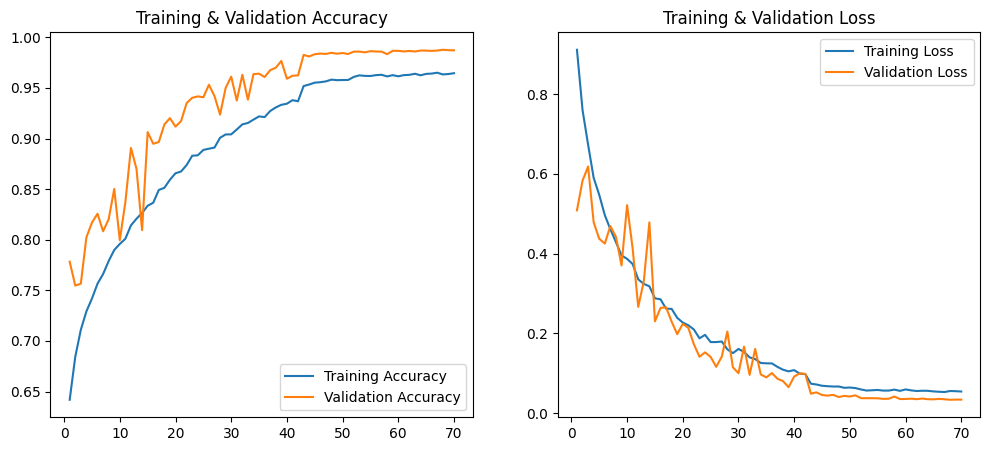

In [ ]:
# Extract data from fine_tune_history
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.show()

**Evaluation(Unfrozen Model)**

**a.Evaluate on Test Set(Unfrozen Model)**

In [ ]:
# Step 1: Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

203/203 ━━━━━━━━━━━━━━━━━━━━ 32s 154ms/step - accuracy: 0.9916 - loss: 0.0218

Test Accuracy: 0.9887
Test Loss: 0.0310


In [ ]:
# Step 2: Get true labels and predicted labels
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict probabilities
Y_pred_probs = model.predict(test_generator)
Y_pred = np.argmax(Y_pred_probs, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 31s 150ms/step


**b. Classification Report(Unfrozen Model)**

In [ ]:
# Step 3: Classification Report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels))


Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       751
 Moderate Dementia       1.00      1.00      1.00        74
      Non Demented       0.99      0.99      0.99     10084
Very mild Dementia       0.96      0.97      0.97      2060

          accuracy                           0.99     12969
         macro avg       0.99      0.99      0.99     12969
      weighted avg       0.99      0.99      0.99     12969



**c. Confusion Matrix(Unfrozen Model)**

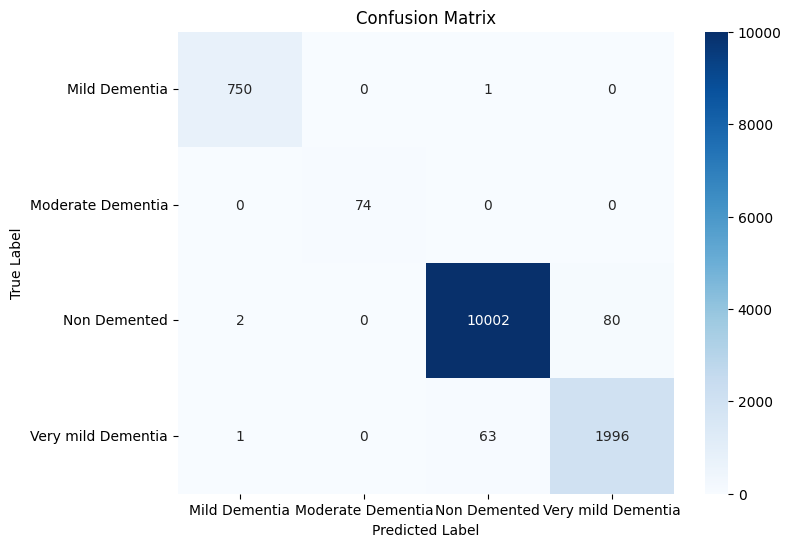

In [ ]:
# Step 4: Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**d. ROC Curve(Unfrozen Model)**

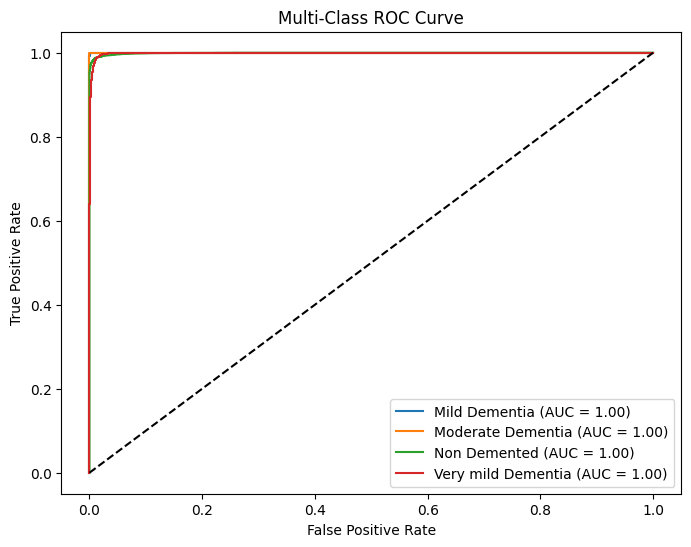

In [ ]:
# Step 5: ROC Curve (multi-class)
# Binarize the true labels for ROC
Y_true_bin = label_binarize(Y_true, classes=range(len(class_labels)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')

plt.show()

**Model Interpretability using Grad-CAM**

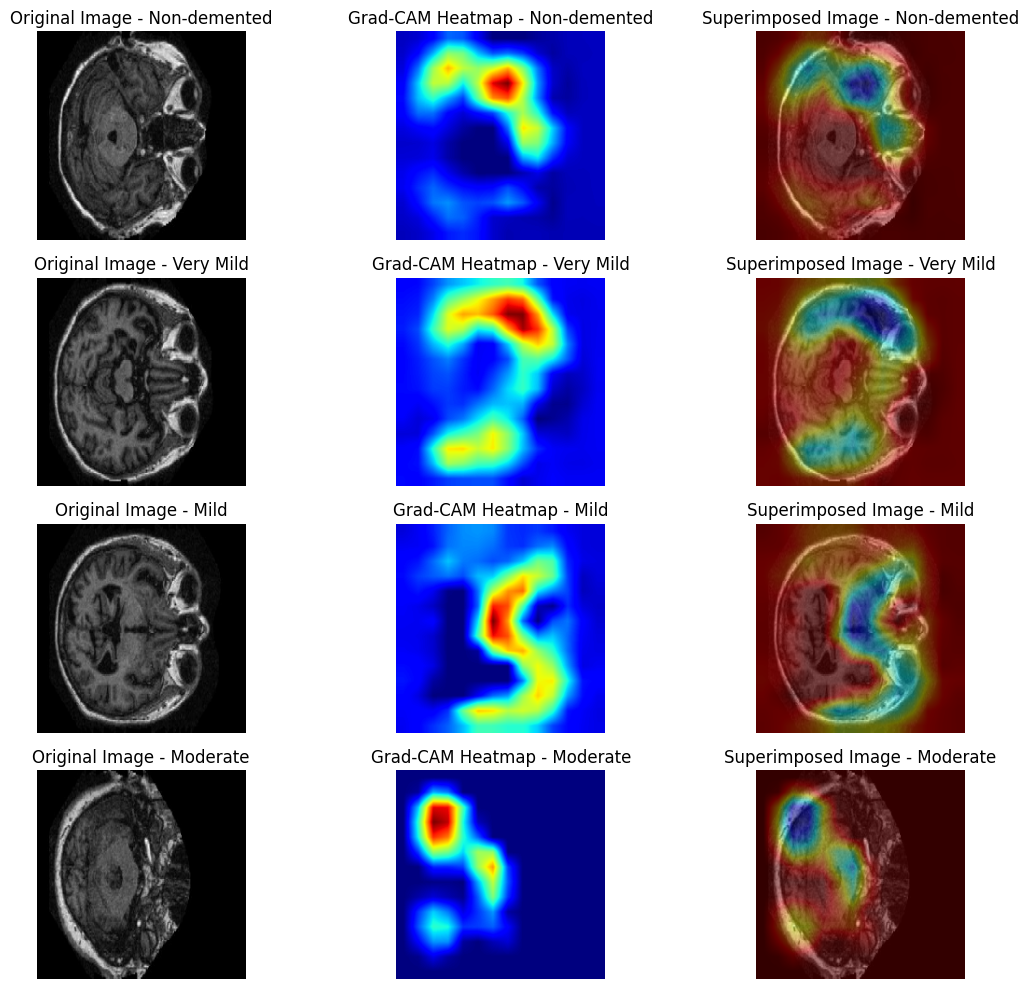

In [ ]:
# class names
class_names = ["Non-demented", "Very Mild", "Mild", "Moderate"]

# Function to compute Grad-CAM for a given image
def generate_grad_cam(img_input, model, last_conv_layer_name="block5_conv3"):
    # Create the grad_model
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_input)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    # Get gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(loss, conv_outputs)

    # Compute channel-wise mean of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by "how important it is"
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (224, 224))

    # Convert image to uint8
    img_uint8 = np.uint8(255 * img_input[0])

    # Apply the heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    return heatmap, superimposed_img

# Loop over all classes and process one image from each class
class_images = []
class_labels = []
for class_index in range(4):
    # Get one image from each class
    while True:
        img_array, label = next(val_generator)
        if np.argmax(label[0]) == class_index:  # Check if the label matches the class
            class_images.append(img_array[0])
            class_labels.append(class_index)  # Store the class index
            break

# Prepare subplots for visualizing the results
fig, axs = plt.subplots(4, 3, figsize=(12, 10))

for idx, img in enumerate(class_images):
    # Expand dimensions to match model input
    img_input = tf.expand_dims(img, axis=0)

    # Generate Grad-CAM and Superimposed image
    heatmap, superimposed_img = generate_grad_cam(img_input, model)

    # Plot the images with class names in titles
    axs[idx, 0].imshow(img)
    axs[idx, 0].set_title(f"Original Image - {class_names[class_labels[idx]]}")
    axs[idx, 0].axis('off')

    axs[idx, 1].imshow(heatmap, cmap='jet')
    axs[idx, 1].set_title(f"Grad-CAM Heatmap - {class_names[class_labels[idx]]}")
    axs[idx, 1].axis('off')

    axs[idx, 2].imshow(superimposed_img)
    axs[idx, 2].set_title(f"Superimposed Image - {class_names[class_labels[idx]]}")
    axs[idx, 2].axis('off')

plt.tight_layout()
plt.show()


**Data Preparation for Models with no Augmentation**

In [ ]:
# Paths for each set
train_path = '/content/OASIS_Data_Split/train'
val_path = '/content/OASIS_Data_Split/val'
test_path = '/content/OASIS_Data_Split/test'

# Only rescale
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    '/content/OASIS_Data_Split/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    '/content/OASIS_Data_Split/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Test generator
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

Found 60504 images belonging to 4 classes.
Found 12964 images belonging to 4 classes.
Found 12969 images belonging to 4 classes.


**Building VGG16 Model(Frozen+NoAugmentation)**

In [ ]:
# VGG16 Base
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))
base_model.trainable = False #freeze initially

# Custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

**Training VGG16 Model(Frozen+NoAugmentation)**

In [ ]:
checkpoint_path = '/content/drive/MyDrive/best_vgg16_model.keras'

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Train the frozen model
history_no_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


946/946 ━━━━━━━━━━━━━━━━━━━━ 239s 227ms/step - accuracy: 0.3299 - loss: 1.3952 - val_accuracy: 0.5448 - val_loss: 1.1695 - learning_rate: 1.0000e-04
Epoch 2/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 182s 192ms/step - accuracy: 0.4922 - loss: 1.2199 - val_accuracy: 0.5920 - val_loss: 1.0798 - learning_rate: 1.0000e-04
Epoch 3/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 182s 192ms/step - accuracy: 0.5530 - loss: 1.1415 - val_accuracy: 0.5670 - val_loss: 1.0965 - learning_rate: 1.0000e-04
Epoch 4/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 182s 192ms/step - accuracy: 0.5932 - loss: 1.0746 - val_accuracy: 0.6061 - val_loss: 1.0366 - learning_rate: 1.0000e-04
Epoch 5/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 182s 192ms/step - accuracy: 0.6190 - loss: 1.0129 - val_accuracy: 0.6500 - val_loss: 0.9392 - learning_rate: 1.0000e-04
Epoch 6/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 181s 192ms/step - accuracy: 0.6247 - loss: 0.9867 - val_accuracy: 0.5626 - val_loss: 1.1014 - learning_rate: 1.0000e-04
Epoch 7/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 182s 192ms/

**Visualizing Training and Validation Accuracy/Loss(Frozen Model with No Augmentation)**

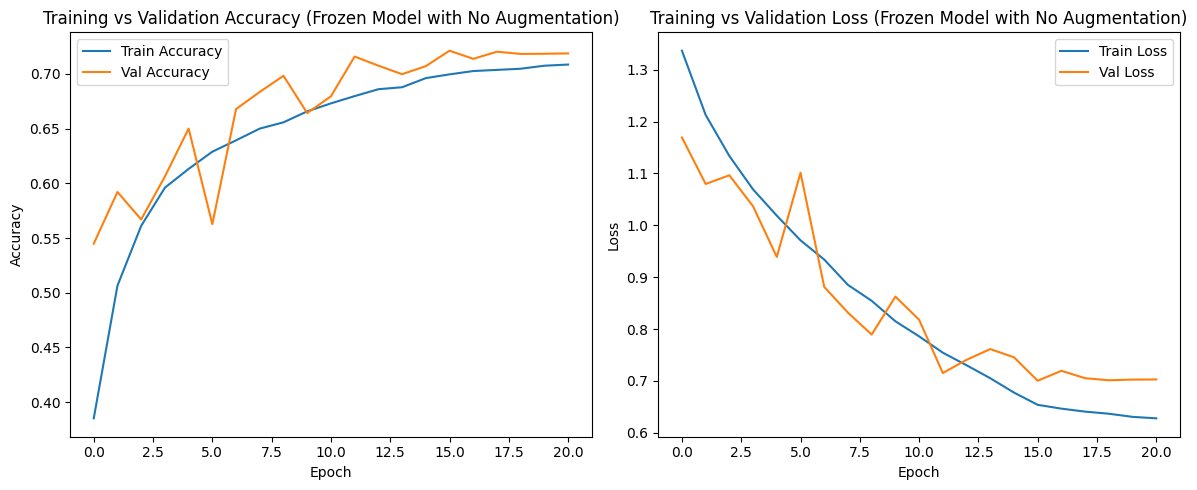

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_no_aug.history['accuracy'],  label='Train Accuracy')
plt.plot(history_no_aug.history['val_accuracy'],  label='Val Accuracy')
plt.title('Training vs Validation Accuracy (Frozen Model with No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_no_aug.history['loss'], label='Train Loss')
plt.plot(history_no_aug.history['val_loss'],  label='Val Loss')
plt.title('Training vs Validation Loss (Frozen Model with No Augmentation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

**Model Evaluation**

**a.Evaluate on Test Set(Frozen Model with No Augmentation)**

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

203/203 ━━━━━━━━━━━━━━━━━━━━ 46s 224ms/step - accuracy: 0.7409 - loss: 0.6763
Test Accuracy: 72.03%
Test Loss: 0.6973


In [ ]:
# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


203/203 ━━━━━━━━━━━━━━━━━━━━ 33s 160ms/step


**b. Confusion Matrix (Frozen Model with No Augmentation)**

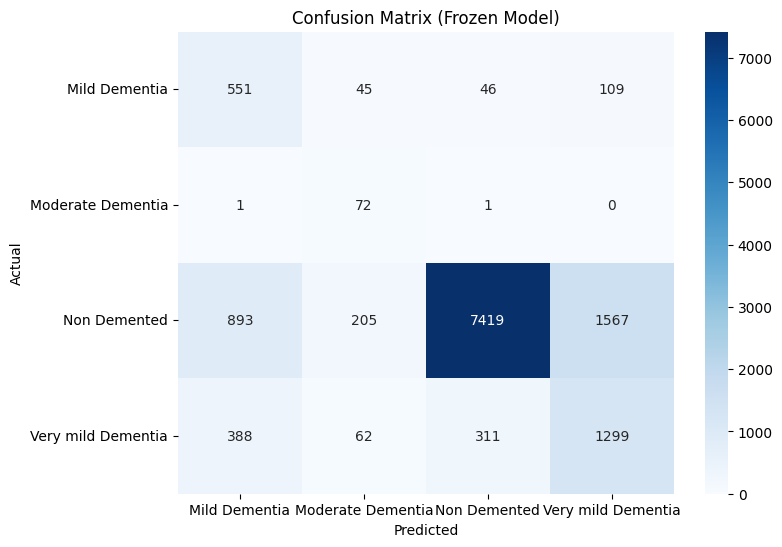

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix (Frozen Modelwith No Augmentation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**c. Classification report(Frozen Model with No Augmentation)**

In [ ]:
# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

                    precision    recall  f1-score   support

     Mild Dementia       0.30      0.73      0.43       751
 Moderate Dementia       0.19      0.97      0.31        74
      Non Demented       0.95      0.74      0.83     10084
Very mild Dementia       0.44      0.63      0.52      2060

          accuracy                           0.72     12969
         macro avg       0.47      0.77      0.52     12969
      weighted avg       0.83      0.72      0.75     12969



**d. ROC Curve(Frozen Model with No Augmentation)**

203/203 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step


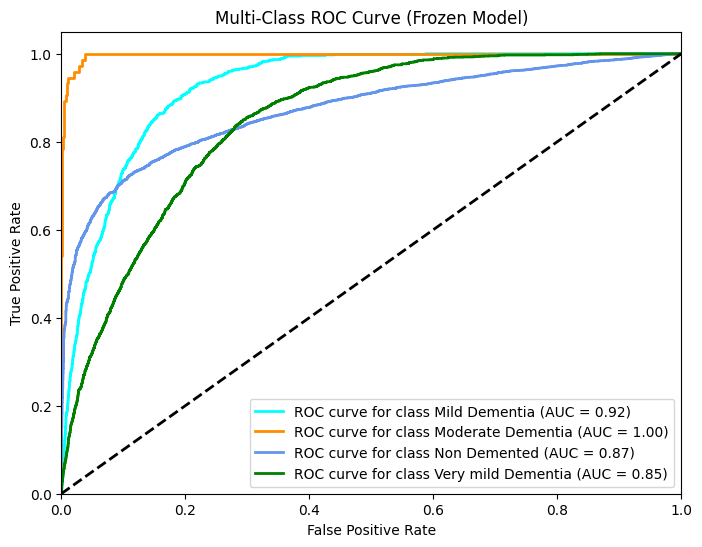

In [ ]:
# Get true labels and predicted probabilities
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
n_classes = y_pred_probs.shape[1]

# Binarize the true labels for ROC computation
y_true_bin = label_binarize(y_true, classes=range(n_classes))
class_names = list(test_generator.class_indices.keys())

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve for class {class_names[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Frozen Model with No Augmentation)')
plt.legend(loc='lower right')

plt.show()

**Training VGG16 Model(Unfrozen + No Augmentation)**

In [ ]:
# Unfreeze the last 4 VGG layers
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Compile with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
callbacks = [
    ModelCheckpoint('best_finetuned_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)
]

# Fit the model
fine_tune_history_no_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=70,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/70


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7207 - loss: 0.5911
Epoch 1: val_accuracy improved from -inf to 0.83346, saving model to best_finetuned_model.keras
946/946 ━━━━━━━━━━━━━━━━━━━━ 206s 210ms/step - accuracy: 0.7208 - loss: 0.5910 - val_accuracy: 0.8335 - val_loss: 0.4216 - learning_rate: 1.0000e-05
Epoch 2/70
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.8597 - loss: 0.2389
Epoch 2: val_accuracy improved from 0.83346 to 0.92402, saving model to best_finetuned_model.keras
946/946 ━━━━━━━━━━━━━━━━━━━━ 193s 204ms/step - accuracy: 0.8597 - loss: 0.2389 - val_accuracy: 0.9240 - val_loss: 0.2097 - learning_rate: 1.0000e-05
Epoch 3/70
946/946 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9239 - loss: 0.1296
Epoch 3: val_accuracy improved from 0.92402 to 0.96251, saving model to best_finetuned_model.keras
946/946 ━━━━━━━━━━━━━━━━━━━━ 193s 204ms/step - accuracy: 0.9239 - loss: 0.1296 - val_accuracy: 0.9625 - val_loss: 0.1194 - learning_rate: 1.0000e-05
Epoch 

**Visualizing Training and Validation Accuracy/Loss(Unfrozen + No Augmentation)**

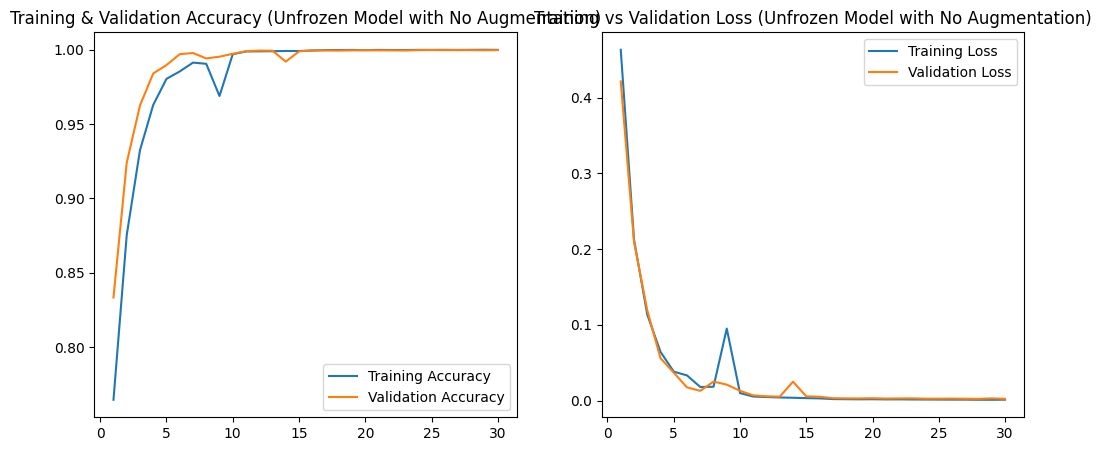

In [ ]:
# Extract data from fine_tune_history
acc = fine_tune_history_no_aug.history['accuracy']
val_acc = fine_tune_history_no_aug.history['val_accuracy']
loss = fine_tune_history_no_aug.history['loss']
val_loss = fine_tune_history_no_aug.history['val_loss']

epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy (Unfrozen Model with No Augmentation)')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss (Unfrozen Model with No Augmentation)')

plt.show()

**Model Evaluation**

**a.Evaluate on Test Set(Unfrozen Model with No Augmentation)**

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

203/203 ━━━━━━━━━━━━━━━━━━━━ 30s 147ms/step - accuracy: 1.0000 - loss: 0.0016

Test Accuracy: 0.9999
Test Loss: 0.0021


In [ ]:
# Get true labels and predicted labels
Y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Predict probabilities
Y_pred_probs = model.predict(test_generator)
Y_pred = np.argmax(Y_pred_probs, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(64, 224, 224, 3))
  warnings.warn(msg)


202/203 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_23']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


203/203 ━━━━━━━━━━━━━━━━━━━━ 31s 149ms/step


**b.Classification Report(Unfrozen Model with No Augmentation)**

In [ ]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=class_labels))


Classification Report:

                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00       751
 Moderate Dementia       1.00      1.00      1.00        74
      Non Demented       1.00      1.00      1.00     10084
Very mild Dementia       1.00      1.00      1.00      2060

          accuracy                           1.00     12969
         macro avg       1.00      1.00      1.00     12969
      weighted avg       1.00      1.00      1.00     12969



**c. Confusion Matrix(Unfrozen Model with No Augmentation)**

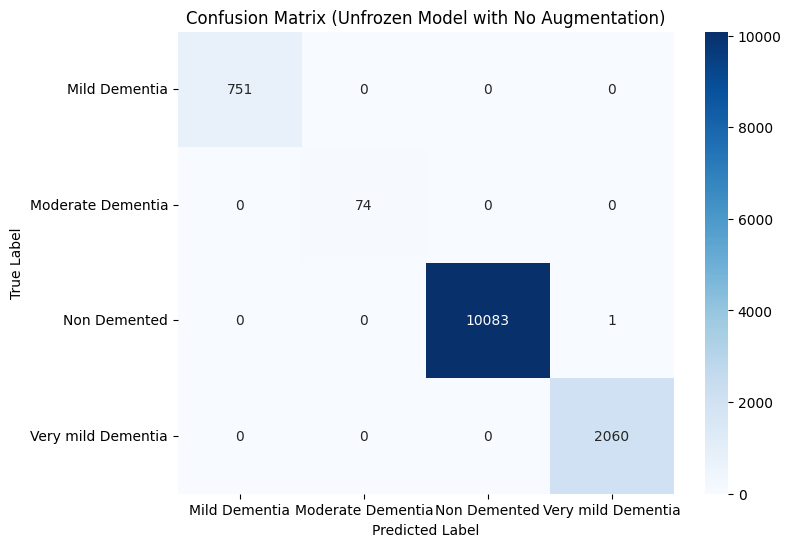

In [ ]:
# Confusion Matrix
cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix (Unfrozen Model with No Augmentation)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**ROC Curve(Unfrozen Model with No Augmentation)**

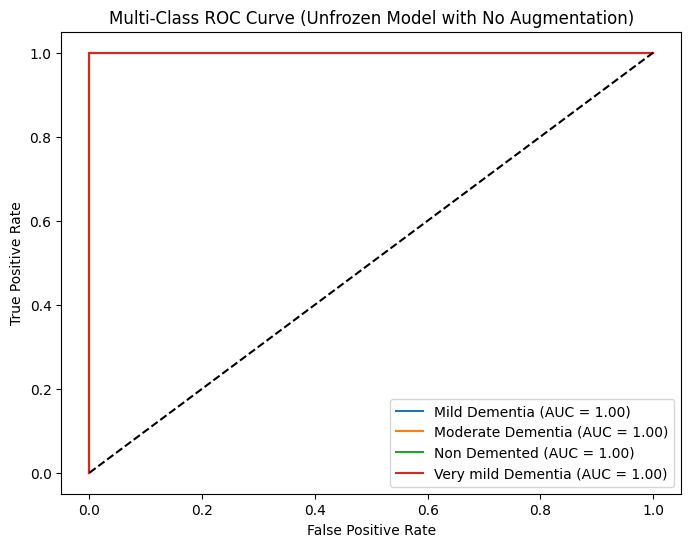

In [ ]:
# ROC Curve
# Binarize the true labels for ROC
Y_true_bin = label_binarize(Y_true, classes=range(len(class_labels)))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(Y_true_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')  # random guess line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (Unfrozen Model with No Augmentation)')
plt.legend(loc='lower right')

plt.show()